# Transformers: Is attention all you need for Text Classification?

In this third solution I want to go a step beyond to apply the most advanced methodologies in the NLP state-of-the-art: Transformers. We have already discussed Transformers in class, as well as their advantages over other methodologies. 

There is still some controversy about what technique is better suited for Text Classification (and NLP in general): RNNs or Transformers. Different research works suggest different experimental results. Nevertheless, it seems that Transformer-based models are starting to outperform RNN-based systems. Let's check what happens in our problem. 

Using Transformes might sound scary (many hyperparameters, you have to deal with tensor, shapes, transform your data....). However, there are a number of libraries and wrappers that will make your life easier (or at least less miserable). In particular, in this solution I will make use of two of them, which I strongly recommend you to use if you want to experiment with these ideas:

 - [HuggingFace](https://huggingface.co/): They provide under the [`transformers`](https://github.com/huggingface/transformers) library a large number of pre-trained state-of-the-art pretrained NLP models together with some handy functions to load them, fine-tune them and put them into practice.
 - [ktrain](https://github.com/amaiya/ktrain): Python library that provides a higher-level wrapper that facilitates the use of Deep Learning based NLP models (HuggingFace models among them).

Let the fun begin!

**Disclaimer:This solution is based on this [post](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed) as well as in the [ktrain](https://github.com/amaiya/ktrain) library documentation**



The first thing to do is to install the required libraries via pip. Ktrain already provides the HuggingFace models so we can skip the installation of HuggingFace and move on to install ktrain. It requires Tensorflow 2.0, so we should install it first.


In [ ]:
# !pip3 install -q tensorflow_gpu>=2.0
# import tensorflow as tf
# print(tf.__version__)



In [ ]:
! pip3 install -q ktrain
! pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
! pip3 install git+https://github.com/amaiya/stellargraph@no_tf_dep_082

     |████████████████████████████████| 25.2MB 1.4MB/s 
     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 983kB 54.6MB/s 
     |████████████████████████████████| 245kB 56.6MB/s 
     |████████████████████████████████| 645kB 52.8MB/s 
     |████████████████████████████████| 471kB 51.3MB/s 
     |████████████████████████████████| 3.9MB 57.0MB/s 
     |████████████████████████████████| 450kB 61.9MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 3.8MB 52.6MB/s 
     |████████████████████████████████| 1.0MB 59.9MB/s 
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-pqxuolj4
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-pqxuolj4
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_

# Data Loading

ktrain directly works with pandas dataframes, which is very handy. Internally, Tensorflow manages a series of Tensors (multidimensional matrices) that need to be create from the pandas dataframes. Some years ago, we need to create them by formating and reshaping our data. Luckily for you, libraries like ktrain (or fast.ai that we used in the other markdown) abstract you from this process.

I am not going to further preprocess the data (since I want to focus on the application of Transformers). For more on this prep-process check my original solution (the one based on regular ML) where I try several ideas.


In [ ]:
# I needed this to load data from my GDrive
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd

training_df = pd.read_csv('./nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df.head(20)

,keyword,location,text,target
0,injured,Kolkata,Terrorists attack police post; 2 SPOs injured ...,1
1,violent%20storm,"Watertown, Mass.",Violent Storm Causes Damage Flooding in Watert...,1
2,obliteration,Ontario,Path of Obliteration\nBack From The Dead\nStor...,1
3,attack,London.,The fact that the atomic bombs were called 'Li...,1
4,obliterated,satan's colon,@horiikawa i played online last night and got ...,0
5,fatalities,NaN,I wonder how Cool/Weird It'll look to have all...,0
6,crash,NaN,@SterlingKnight Who had a car crashsterling!W...,0
7,derailment,India,Trains derailment: 'It's the freakiest of frea...,1
8,derail,NaN,Dozens Die As two Trains Derail Into A River I...,1
9,body%20bags,NaN,Bitches be takin pics with bags bigger than th...,0


In [ ]:
test_df = pd.read_csv('./nlp_disaster/data/test.csv', sep=',', index_col=0)
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Great, we have the data, let's move to the actual modelling.


# STEP 1:  Preprocess Data and Create a Transformer Model

In this step I will take the dataset, preprocess it (via ktrain) and create a Text Classifier based on a Transformer model. This process follows a similar intuition to what we already did with fast.ai in the other markdown, although it is not exactly the same.

We will start again with a Language Model pre-trained using a huge dataset: a model that speaks English. The model in particular is the well-know BERT. We already explained the basic rationale of BERT in class, but just as a reminder: it applies the idea of Self-Attention (instead of an RNN architecture) to learn the sequential information of textual contents. If you want to know more, let me refer you again to this great blog post: http://jalammar.github.io/illustrated-bert/.

As we also did in the other markdown, we have to now fine-tune this model: Retrain the model to our specific dataset and task. In more detail, the BERT model provides a encoder block with pre-trained weights which gives BERT a general understanding of English. The BERT encoder block will look at each input tweet as a whole, producing an output that contains an understanding of the textual content of the tweet. This representation is then feed to a Text classifier. Thanks to ktrain, this process only involves a handful of lines of code.

In [ ]:
import re

def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
 
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    return tweet

In [ ]:
# For progress bar
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas() 

training_df['clean_text'] = training_df['text'].progress_apply(lambda x: clean(x))
test_df['clean_text'] = test_df['text'].progress_apply(lambda x: clean(x))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


In [ ]:
test_df['clean_text'] = test_df['text'].progress_apply(lambda x: clean(x))


### BERT Model


In [ ]:
import ktrain
from ktrain import text

trn, val, preproc = text.texts_from_df(training_df,'clean_text',preprocess_mode='bert',label_columns='target',verbose=True) # Process the input tweets based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=6) # Creates the learning process to fine-tune bert and train the classifier.

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


Is Multi-Label? False
maxlen is 400
done.


### ROBERTA model

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(training_df.clean_text, training_df.target, test_size=0.2)
x_train, x_test, y_train, y_test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


In [ ]:
import ktrain
from ktrain import text

MODEL_NAME = 'roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=training_df.target.unique().tolist())
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=4)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:367: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 35


preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


# STEP 2:  Train the Model

It is now time to actually train (fine-tuning + train the text classifier) the model. This process might take a while. BERT is huge and memory-hungry. Consequently, it is pretty slow for both training and prediction. 

Since our dataset is not very large, you can train the model in a reasonable amount of time if you have a GPU at your disposal (if you don't just use Google Colab or another platform offering GPUs as I did. Do not try to train this model in your laptop if you do not want to potentially wait for hours). 

Nevertheless, because of this complexity, BERT is not very suitable for production environments. In this sense, I recommend you to take a look to DistilBERT. DistillBERT is a “distilled” (a.k.a. reduced) version of BERT that is smaller and faster while retaining most of BERT’s accuracy. Check this blog post from HuggingFace for more details on DistillBERT and the whole idea of Knowledge Distillation: https://medium.com/huggingface/distilbert-8cf3380435b5).

There is many other pre-trained models that HuggingFace provides. You can check the entire Model zoo in the following link: https://huggingface.co/transformers/pretrained_models.html.

As always, the first thing to do is to decide what's gonna be the learning rate.Like fast.ai, ktrain provides a way of testing different learning rates and plot the results so you can select the optimal one.

simulating training for different learning rates... this may take a few moments...
Train on 6851 samples
Epoch 1/2
6851/6851 [==============================] - 678s 99ms/sample - loss: 0.6043 - accuracy: 0.6730
Epoch 2/2
1932/6851 [=======>......................] - ETA: 7:54 - loss: 1.1355 - accuracy: 0.5145

done.
Visually inspect loss plot and select learning rate associated with falling loss


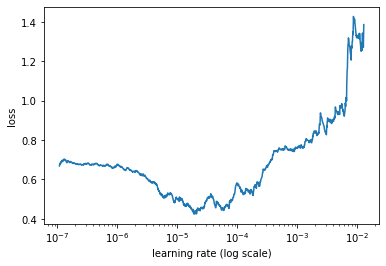

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

As we already now, we want a learning rate which is more or less in the middle of the steeper slope of the loss function. In our case is somewhere about 1e-6. I have selected 5e-6, but I encourage you to try different value.

I will train the model for a couple of epochs and see what happens.

In [ ]:
# learner.fit_onecycle(7e-6, 3)
learner.autofit(lr=5e-6, epochs=10, early_stopping=2, reduce_on_plateau=1, monitor='val_accuracy')



begin training using triangular learning rate policy with max lr of 5e-06...
Train on 6851 samples, validate on 762 samples
Epoch 1/10
6851/6851 [==============================] - 680s 99ms/sample - loss: 0.4742 - accuracy: 0.7819 - val_loss: 0.4238 - val_accuracy: 0.8150
Epoch 2/10
6851/6851 [==============================] - 686s 100ms/sample - loss: 0.3490 - accuracy: 0.8570 - val_loss: 0.4076 - val_accuracy: 0.8215
Epoch 3/10
6851/6851 [==============================] - 682s 100ms/sample - loss: 0.2958 - accuracy: 0.8818 - val_loss: 0.4294 - val_accuracy: 0.8320
Epoch 4/10
6846/6851 [============================>.] - ETA: 0s - loss: 0.2426 - accuracy: 0.9055
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-06 (if not early_stopping).
6851/6851 [==============================] - 678s 99ms/sample - loss: 0.2425 - accuracy: 0.9056 - val_loss: 0.4958 - val_accuracy: 0.8136
Weights from best epoch have been loaded into model.


Impressive! Just to epochs and we get almost 85% of accuracy. Way better than our Machine Learning models but also than the model based on LSTMs that we trained using fast.ai.

In [ ]:
learner.unfreeze()
learner.fit_onecycle(5e-6/10, 1)



begin training using onecycle policy with max lr of 5.000000000000001e-07...
Train on 6851 samples, validate on 762 samples
6851/6851 [==============================] - 690s 101ms/sample - loss: 0.2856 - accuracy: 0.8908 - val_loss: 0.4165 - val_accuracy: 0.8228


# STEP 3: Evaluate and Inspect the Model

I do have now a pretty good model, so in this section I will take a look to its results, visualize what's going on and to finally create the final submission file to submit to Kaggle.

First I will create the confussion matrix to understand the performance of the model and to check the F-measure.


In [ ]:
learner.validate(class_names=['Regular Tweet','Disaster Tweet'])

                precision    recall  f1-score   support

 Regular Tweet       0.86      0.91      0.88       893
Disaster Tweet       0.87      0.78      0.82       630

      accuracy                           0.86      1523
     macro avg       0.86      0.85      0.85      1523
  weighted avg       0.86      0.86      0.86      1523



array([[816,  77],
       [136, 494]])

The model is a little bit better on detecting regular tweets; I guess that this is because we have more of those. Anyhow, it works pretty well for both classes in terms of accuracy and F-measure.


If you want to better understand how the model is working (something that it's very important since Deep Learning models are usually pretty black-boxy), ktrain provides some useful techniques.

You can examine the validation tweets about which the model was the most wrong (i.e., the top losses).

In [ ]:
learner.view_top_losses(n=10, preproc=preproc)

----------
id:674 | loss:5.35 | true:0 | pred:1)

[CLS] disaster ave ##rted : police kill gun ##man with hoax device at ##cine ##ma [SEP]
----------
id:280 | loss:5.22 | true:0 | pred:1)

[CLS] cabin fever 2 flames [SEP]
----------
id:197 | loss:3.81 | true:0 | pred:1)

[CLS] ' up to 40 % of businesses affected by a natural or man - made disaster never re ##open ' [SEP]
----------
id:365 | loss:3.58 | true:0 | pred:1)

[CLS] san bernardino i ##10 w e ##o / red ##lands b ##l ##vd * * traffic collision - no in ##j * * [SEP]
----------
id:591 | loss:3.48 | true:0 | pred:1)

[CLS] our garbage truck really caught on fire l ##m ##fa ##o . [SEP]
----------
id:513 | loss:3.23 | true:0 | pred:1)

[CLS] thief broke front window of hicks ##ville store stole 50 cell phones ; fled crashed into . . . [SEP]
----------
id:271 | loss:3.19 | true:0 | pred:1)

[CLS] dr . jim & the tsunami : the latest new yorker warned us in no uncertain terms . haven ' t you heard ? the tsunami ' s . . . [SEP]
---------

For example, the tweet that my model is the most wrong about is:

`[CLS] # hot c - 130 specially modified to land in a stadium and rescue h ostages in iran in 1980 ...`

This tweet is not talking about any disaster, but about a C-130 modified to solve a hostage situation. This guy over here:

<img src="https://wonderfulengineering.com/wp-content/uploads/2015/11/C-130-rocket-for-Iranian-hostage-crisis-610x410.jpg">

However, the model is predicting that the tweet it's about a disaster. I bet you that this is because the wording `land in a stadium and rescue hostages...` seems awfully similar to a disaster situation.



ktrain, actually provides an `explain` method to know that. It allows you to inspect a given tweet and visualize which words contributed the most on deciding the final prediction. We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


And call the `explain` function

In [ ]:
predictor.explain("Japan,#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/wpGvAyfkBQ #prebreak #best")

You can see that as I suspected words like hostages or rescue fool the model to predict that the tweet is about a disaster.

# STEP 4: Making Predictions on New Data in Deployment

Finally, we have to use the `get_predictor` function to create a prediction object that we can later use to predict on new data.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

This `predictor` can be used to predict the category of individual examples

In [ ]:
predictor.predict(training_df.text[4])

You can actually get the probabilities assigned by the model to each class (in case you want to work with them to try different confidence thresholds)

In [ ]:
# predicted probability scores for each category
predictor.predict_proba(training_df.text[4])


We can save and reload our predictor for later deployment.

In [ ]:
predictor.save('./nlp_disaster/bert_models/my_bert_predictor')

In [ ]:
#reloaded_predictor = ktrain.load_predictor('/content/drive/My Drive/nlp_disaster/bert_models/my_bert_predictor')

Finally, I will use the `predictor` to predict the labels of all the test set and create the submission file for Kaggle according to the submission format

In [ ]:
predictions = predictor.predict(list(test_df.clean_text))
submission = pd.DataFrame({'id': test_df.index, 'target': predictions})
submission.to_csv('./nlp_disaster/submission_bert.csv', index=False)

83.5% of accuracy according to Kaggle! Our best model so far. 

Summing up, by applying BERT (perhaps the most advanced NLP methodology) we have been able to improve the representation of our textual content, thus improving the classifier performance.

I hope that thanks to this and the fast.ai markdown you may see that putting Deep Learning ideas into practice for NLP problems is not so difficult anymore thanks to these higher-level frameworks (Keras, fast.ai, HuggingFace, ktrain and many others). Even if you do not have a lot of data, thanks to the most novel work on Transfer Learning you can reuse models pre-trained during weeks in huge datasets and adapt them to your particular domain, yielding state of the art results for many NLP tasks.


# STEP 5: Data Augmentation

This section showcases an ongoing research feature that we have been working on to add to Rasa Open Source.

In order to ensure the BERT is able to handle real world conversations, it needs to anticipate different variations in which their users can express the same intent. The more training data we add, the more robust our NLU models become to incoming user messages.

So we built a paraphrasing model, which takes as input a sentence and generates multiple paraphrased versions of the same sentence.

For example: 

```
input message: I want to book an appointment for tomorrow.

Generated Paraphrases
---------------------

- I want to book an appointment for tomorrow.
- i need to book an appointment for another meeting.
- i want to make an appointment for tomorrow.
- i want to book a spot tomorrow.
- i want to book a reservation for tomorrow.
- we need to book an appointment for tomorrow.
- i want to book an appointment for tomorrow at 11 : 00.
- i 'd like to meet tomorrow.
- i 'd like you to arrange a session for tomorrow.
- i 'll book a reservation for tomorrow.
- i 'd like to book the appointment for tomorrow.
- i 'd like to make an appointment for tomorrow.
```


## Necessary libraries and imports

In [ ]:
!pip install torch torchvision transformers rasa==1.7.0 input_reader

     |████████████████████████████████| 583kB 2.8MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 419kB 40.4MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 40kB 5.5MB/s 
     |████████████████████████████████| 110.8MB 38kB/s 
     |████████████████████████████████| 327kB 37.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 512kB 45.8MB/s 
     |████████████████████████████████| 5.1MB 33.4MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 5.4MB 31.7MB/s 
     |████████████████████████████████| 153kB 41.8MB/s 
     |████████████████████████████████| 1.2MB 34.3MB/s 
     |████████████████████████████████| 665kB 41.8MB/s 
     |████████████████████████████████| 1.6MB 33.5MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     

In [ ]:
from rasa.nlu.training_data import TrainingData,Message
import os
import requests

### Download and setup the paraphrasing model

In [ ]:
### Download model

#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

model_class_file_id = '1N1kn2b7i2ND7eNefzyJM-k13IM8tqZvr'
checkpoint_file_id = '1G0nwXlvzGsb8Ar-OAnYBQKFvY97WMzBy'
model_class_destination = 'model.py'
checkpoint_destination = 'model.zip'
checkpoint_unzipped_destination = 'package_models'

if not os.path.exists(checkpoint_unzipped_destination):
  download_file_from_google_drive(checkpoint_file_id, checkpoint_destination)
  !unzip {checkpoint_destination}

if not os.path.exists(model_class_destination):
  download_file_from_google_drive(model_class_file_id, model_class_destination)

Archive:  model.zip
   creating: package_models/
  inflating: package_models/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/package_models/
  inflating: __MACOSX/package_models/._.DS_Store  
   creating: package_models/lm_finetune_8/
   creating: package_models/lm_finetune_8/checkpoint-56000/
  inflating: package_models/lm_finetune_8/checkpoint-56000/added_tokens.json  
  inflating: package_models/lm_finetune_8/checkpoint-56000/tokenizer_config.json  
  inflating: package_models/lm_finetune_8/checkpoint-56000/special_tokens_map.json  
  inflating: package_models/lm_finetune_8/checkpoint-56000/optimizer.pt  
  inflating: package_models/lm_finetune_8/checkpoint-56000/config.json  
  inflating: package_models/lm_finetune_8/checkpoint-56000/scheduler.pt  
  inflating: package_models/lm_finetune_8/checkpoint-56000/merges.txt  
  inflating: package_models/lm_finetune_8/checkpoint-56000/training_args.bin  
  inflating: package_models/lm_finetune_8/checkpoint-56000/pytorch_model.bin 

In [ ]:
from model import ParaphraseModel
model_path = 'package_models/lm_finetune_8/checkpoint-56000/'

complete_td = TrainingData()
model = ParaphraseModel(model_path)

## Create the paraphrasis

In [ ]:
### Example
print("Input phrase:", training_df.text[0])
paraphrases = model.get_paraphrases(training_df.text[0], 5, stop_words='')
print("Paraphrases")
paraphrases

Input phrase: To All The Meat-Loving Feminists Of The World Riot Grill Has Arrived http://t.co/SkAAUSjpO4 OliviaMiles01


100%|██████████| 20/20 [00:02<00:00,  9.21it/s]

Paraphrases


['for meat loving feminists of the world, we have come to the meat of all feminists of the world',
 'the world of all carnivorous feminists of the world has come together to make up a grill : http',
 "for all world-hating feminists of the world's grill, he was here with a riot",
 "the meat-loving feminists of the world have come back to grill all the way from the world '",
 'to all feminist meat eaters of the world, the kitchen has been here to see http : //']

In [ ]:
augmented_training = []

print(len(training_df))
for ii,(_,row) in enumerate(training_df.iterrows()):
  if ii%100 == 0:
    print("Row", ii, "out of", len(training_df))
  input_phrase = row['clean_text']
  target = row['target']
  paraphrases = model.get_paraphrases(input_phrase, 5, stop_words='')
  for p in paraphrases:
    augmented_training.append({'clean_text':p,'target':target})
  augmented_training_df = pd.DataFrame(augmented_training)               
  augmented_training_df.to_csv('/content/drive/My Drive/nlp_disaster/data/augmented_training.csv', index = False)


7613
Row 0 out of 7613


100%|██████████| 20/20 [00:00<00:00, 39.59it/s]


Row 100 out of 7613


100%|██████████| 20/20 [00:00<00:00, 35.98it/s]


Row 200 out of 7613


100%|██████████| 20/20 [00:00<00:00, 36.49it/s]


In [ ]:
augmented_training_df = pd.DataFrame(augmented_training)               
augmented_training_df.head(20)

In [ ]:
augmented_training_df.to_csv('./nlp_disaster/data/augmented_training.csv', index = False)

In [ ]:
augmented_training_df = pd.read_csv('./nlp_disaster/data/augmented_training.csv')
augmented_training_df.head(5)

,clean_text,target
0,the eyewitness accounts of the children's comp...,1
1,imee rafferty : the amazing story of the closi...,1
2,iced up the report of the children's company's...,1
3,ern r. patrick j butler : this is an excellent...,1
4,excellent testimony of the children's company'...,1


In [ ]:
augmented_training_df = pd.concat([training_df[['clean_text', 'target']],augmented_training_df])
len(augmented_training_df)

14478

## Train the BERT model with the augmented dataset

In [ ]:
import ktrain
from ktrain import text

trn, val, preproc = text.texts_from_df(augmented_training_df,'clean_text',preprocess_mode='bert',label_columns='target',verbose=True) # Process the input tweets based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=6) # Creates the learning process to fine-tune bert and train the classifier.

preprocessing train...
language: en


preprocessing test...
language: en


Is Multi-Label? False
maxlen is 400
done.


simulating training for different learning rates... this may take a few moments...
Train on 13030 samples
Epoch 1/2
13030/13030 [==============================] - 2164s 166ms/sample - loss: 0.6015 - accuracy: 0.6757
Epoch 2/2
 4326/13030 [========>.....................] - ETA: 23:57 - loss: 1.1966 - accuracy: 0.5074

done.
Visually inspect loss plot and select learning rate associated with falling loss


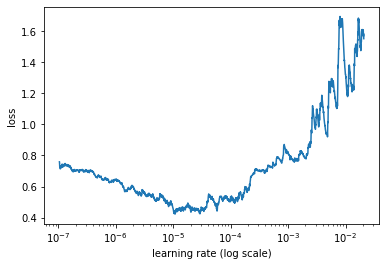

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.fit_onecycle(2e-6, 3)



begin training using onecycle policy with max lr of 2e-06...
Train on 13030 samples, validate on 1448 samples
Epoch 1/3
13030/13030 [==============================] - 2954s 227ms/sample - loss: 0.6018 - accuracy: 0.6744 - val_loss: 0.4613 - val_accuracy: 0.7852
Epoch 2/3
13030/13030 [==============================] - 2913s 224ms/sample - loss: 0.4236 - accuracy: 0.8140 - val_loss: 0.4270 - val_accuracy: 0.8080
Epoch 3/3
13030/13030 [==============================] - 2914s 224ms/sample - loss: 0.3671 - accuracy: 0.8447 - val_loss: 0.4156 - val_accuracy: 0.8191


In [ ]:
learner.unfreeze()
learner.fit_onecycle(2e-6/10, 1)



begin training using onecycle policy with max lr of 2e-07...
Train on 13030 samples, validate on 1448 samples
13030/13030 [==============================] - 2941s 226ms/sample - loss: 0.3439 - accuracy: 0.8588 - val_loss: 0.4155 - val_accuracy: 0.8211


In [ ]:
learner.validate(class_names=['Regular Tweet','Disaster Tweet'])

NameError: ignored

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictions = predictor.predict(list(test_df.clean_text))
submission = pd.DataFrame({'id': test_df.index, 'target': predictions})
submission.to_csv('./nlp_disaster/submission_bert_extended.csv', index=False)